In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.arima_model import ARIMA       
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Some Basic Directories for housekeeping
# set location of input files:
inpDir = os.path.join( '..', 'input')

outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

CMAP = plt.cm.rainbow
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

# Define constants for data manipulation
TEST_SIZE = 0.2
NOISE = 0.2
N_SAMPLE = 1024

<Figure size 640x480 with 0 Axes>

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',    
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 75,
          'image.cmap': 'summer',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }


plt.rcParams.update(params)

'''plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))
'''
np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

In [4]:
data_df=pd.read_csv(os.path.join(inpDir, 'website_data.csv'))
data_df

,traffic
0,932
1,929
2,938
3,964
4,990
...,...
388,4667
389,4701
390,4721
391,4757


In [5]:
data_df.head()

,traffic
0,932
1,929
2,938
3,964
4,990


In [6]:
data_df.describe()

,traffic
count,393.00
mean,3046.52
std,1198.71
min,913.00
25%,2039.00
50%,2802.00
75%,4355.00
max,4941.00


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [8]:
data_df.isnull().sum()

traffic    0
dtype: int64

In [9]:
# Function to plot signal, ACF and PACF
def plotds(xt, nlag = 30, fig_size = (12,10)):
    
    if not isinstance(xt, pd.Series):
        
        xt = pd.Series(xt)
        
    plt.figure(figsize = fig_size)
    
    layout = (2,2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0,0), colspan = 2)
    ax_acf = plt.subplot2grid(layout, (1,0))
    ax_pacf = plt.subplot2grid(layout, (1,1))
    
    # Plot graphs
    xt.plot(ax = ax_xt)
    
    ax_xt.set_title('Time Series')
    
    plot_acf(xt, lags = nlag, ax = ax_acf)
    
    plot_pacf(xt, lags = nlag, ax = ax_pacf)
    
    plt.tight_layout()
    
    return

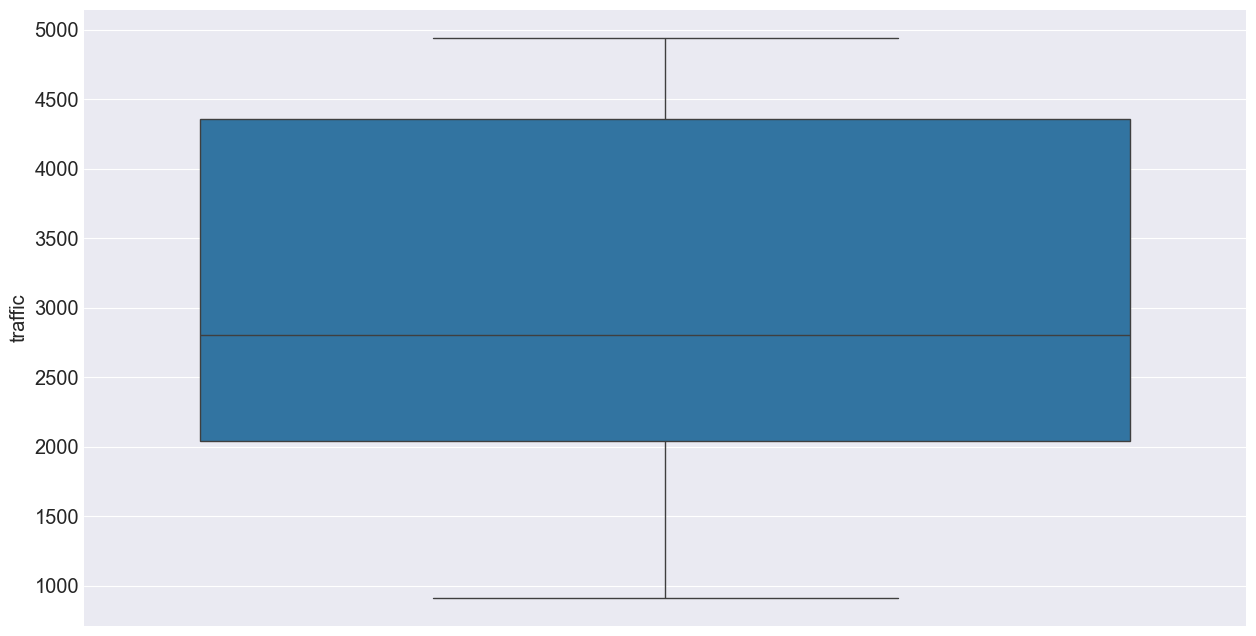

In [10]:
ax = sns.boxplot(data = data_df, y = 'traffic')

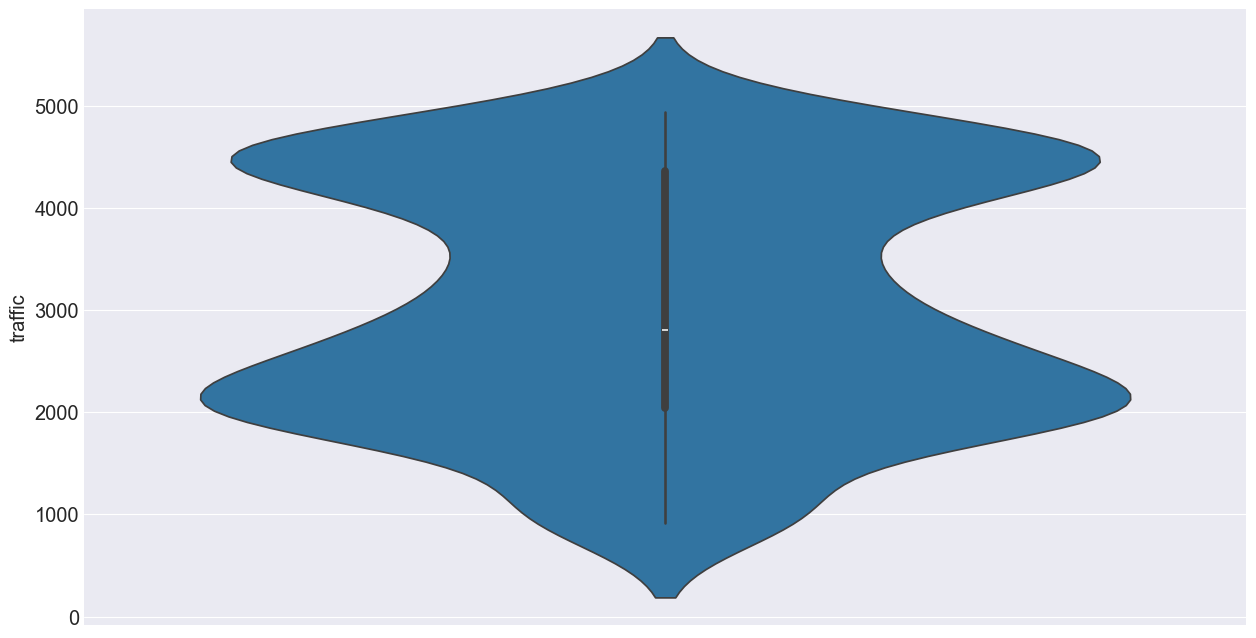

In [11]:
ax = sns.violinplot(data = data_df, y = 'traffic')

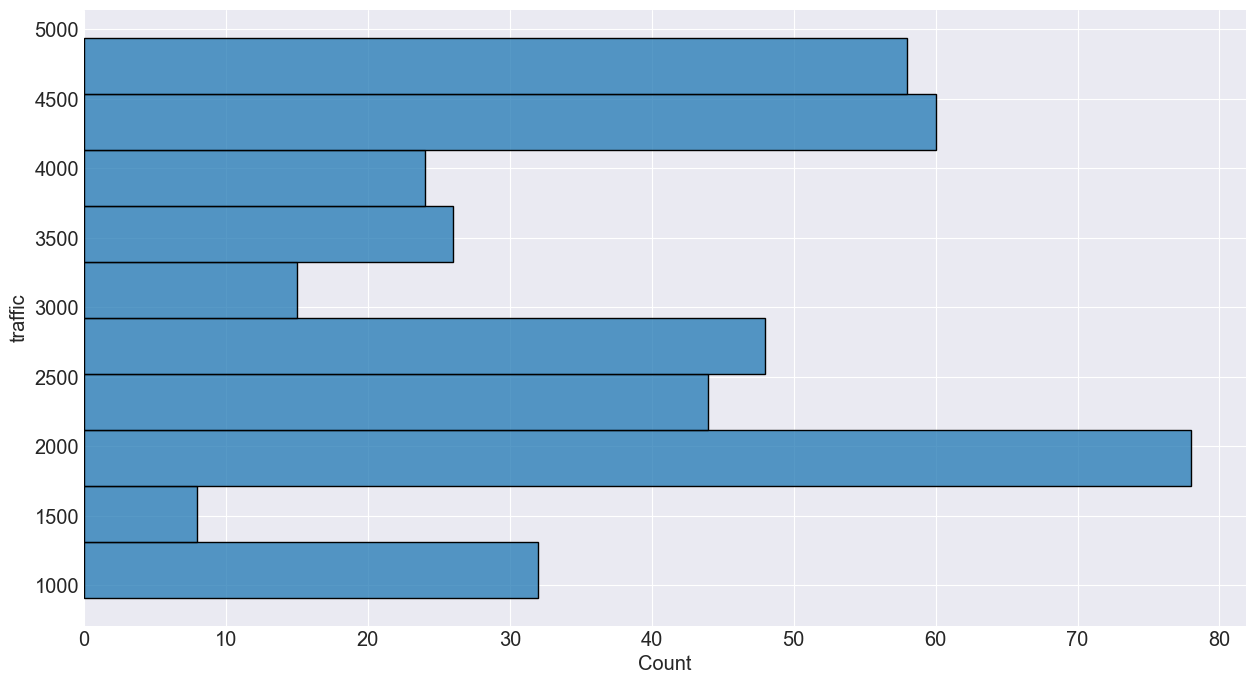

In [12]:
ax = sns.histplot(data = data_df, y = 'traffic')

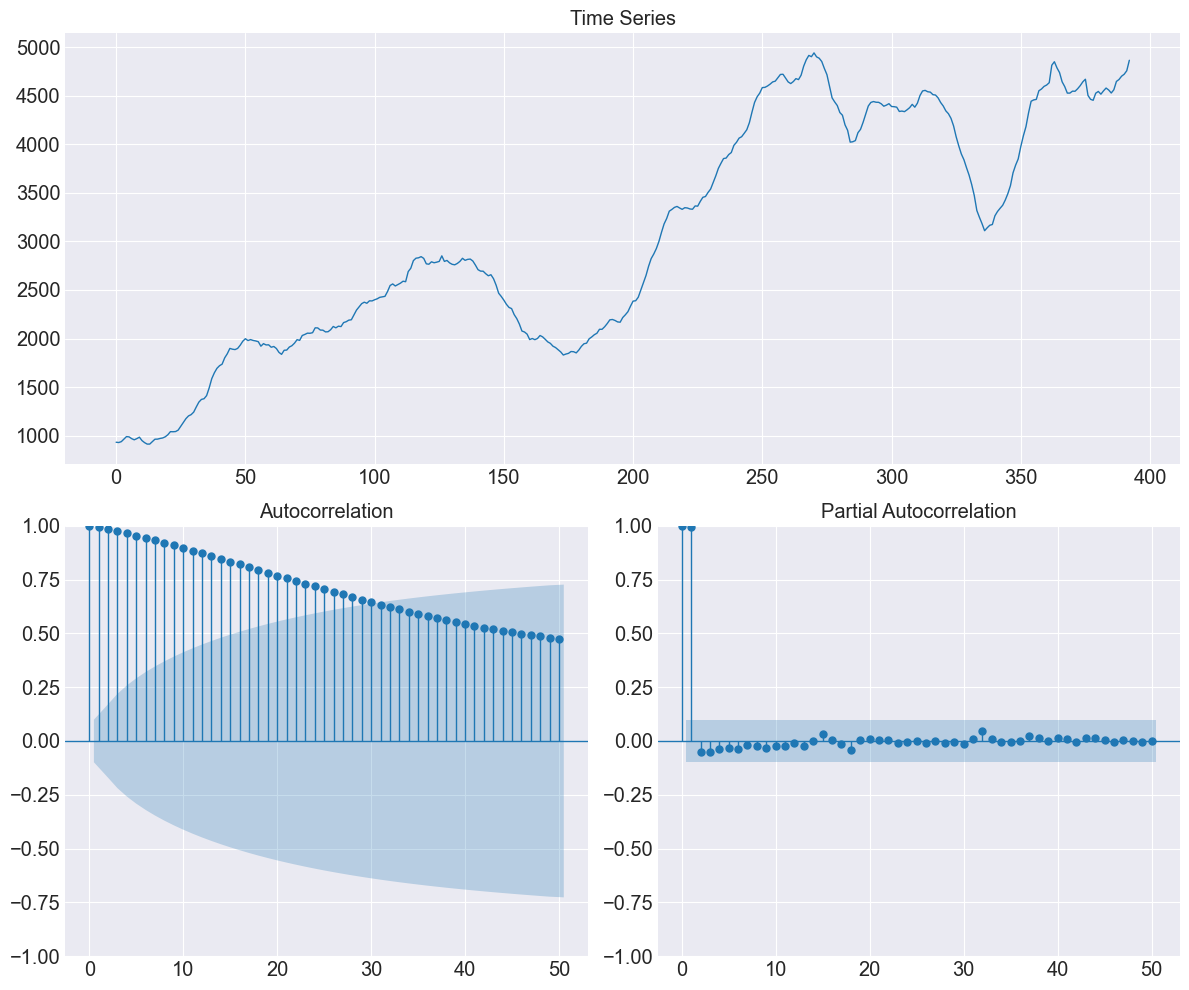

In [13]:
plotds(data_df['traffic'],nlag = 50)

In [14]:
train_df = data_df.iloc[:360]
test_df = data_df.iloc[360:]

train_df.shape, test_df.shape

((360, 1), (33, 1))

In [15]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_df.to_numpy(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observation Uses'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput) 

Test Statistic                 -1.47
p-value                         0.55
#Lags Used                     16.00
Number of Observation Uses    343.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


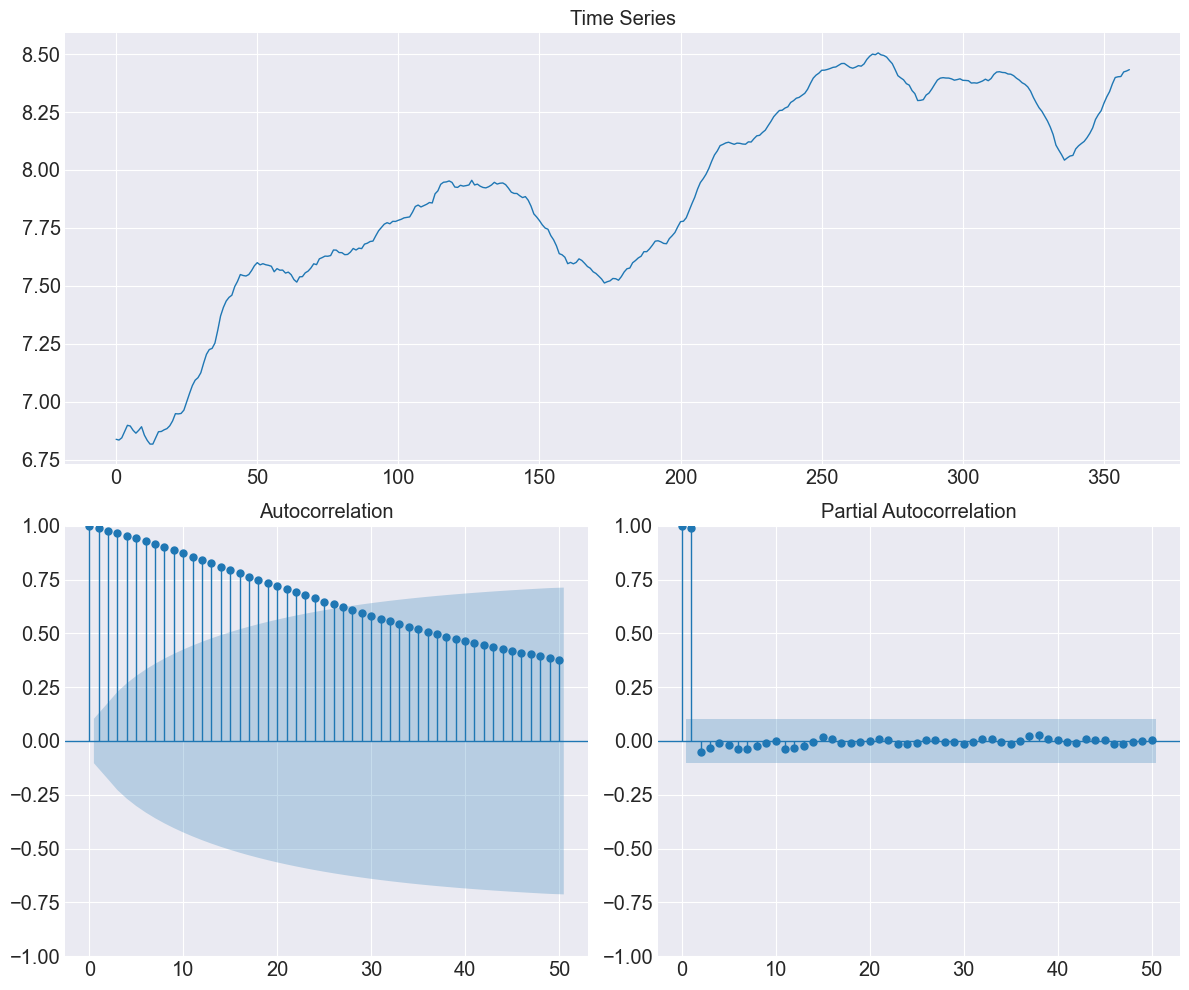

In [16]:
# Making the series stationary
train_log_df = train_df.copy()

train_log_df['traffic'] = np.log(train_log_df['traffic'])

plotds(train_log_df['traffic'], nlag = 50)

In [17]:
dftest = adfuller(train_log_df.to_numpy(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observation Uses'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput) 

Test Statistic                 -2.40
p-value                         0.14
#Lags Used                     16.00
Number of Observation Uses    343.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


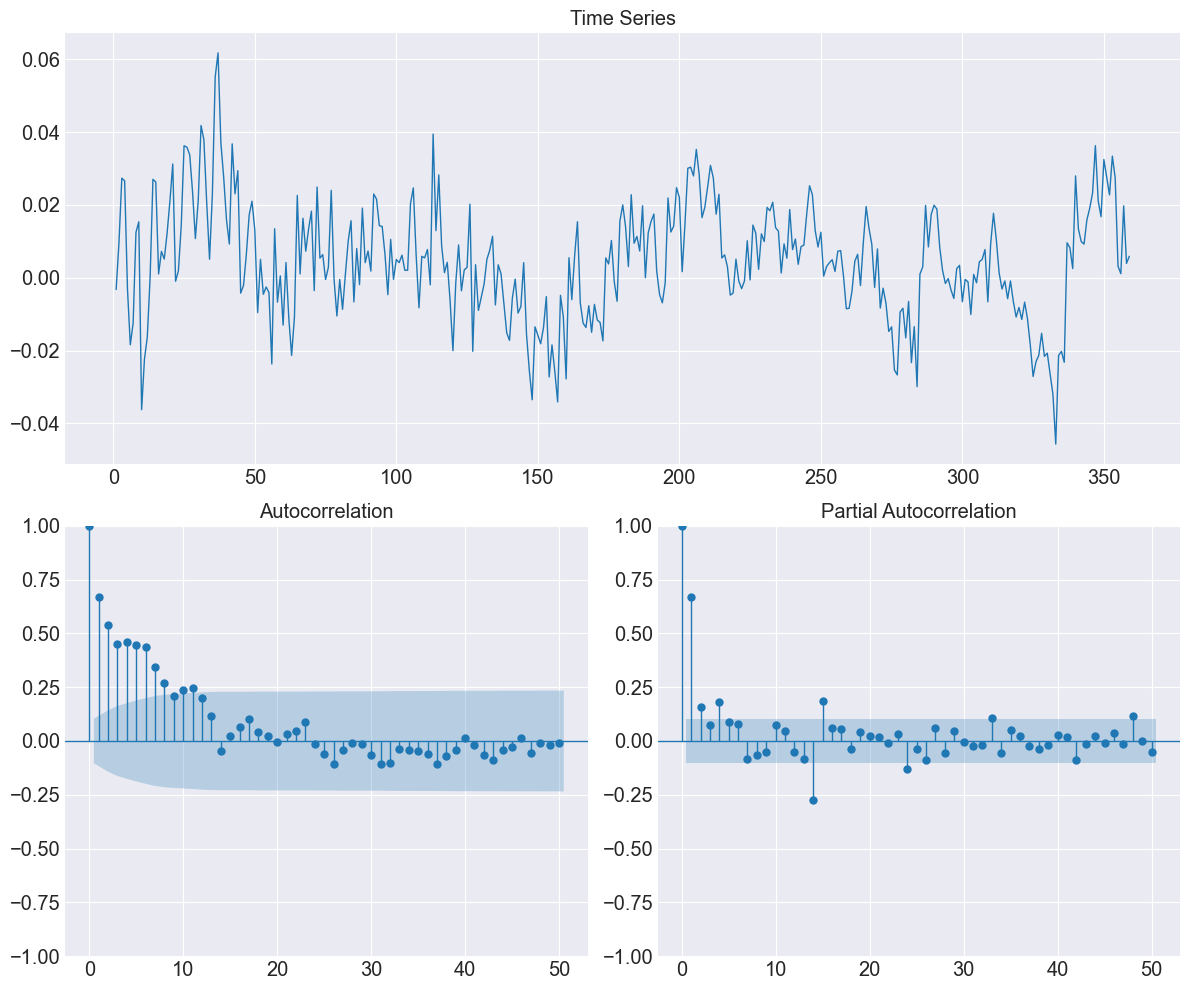

In [18]:
diff_train_df = train_log_df.diff().dropna()

plotds(diff_train_df['traffic'], nlag = 50)

In [19]:
dftest = adfuller(diff_train_df.to_numpy(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic',
                                         'p-value',
                                         '#Lags Used',
                                         'Number of Observation Uses'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput) 

Test Statistic                 -3.42
p-value                         0.01
#Lags Used                     15.00
Number of Observation Uses    343.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [22]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff_train_df, order = (2,1,0))

res = model.fit()

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Axes: ylabel='Density'>

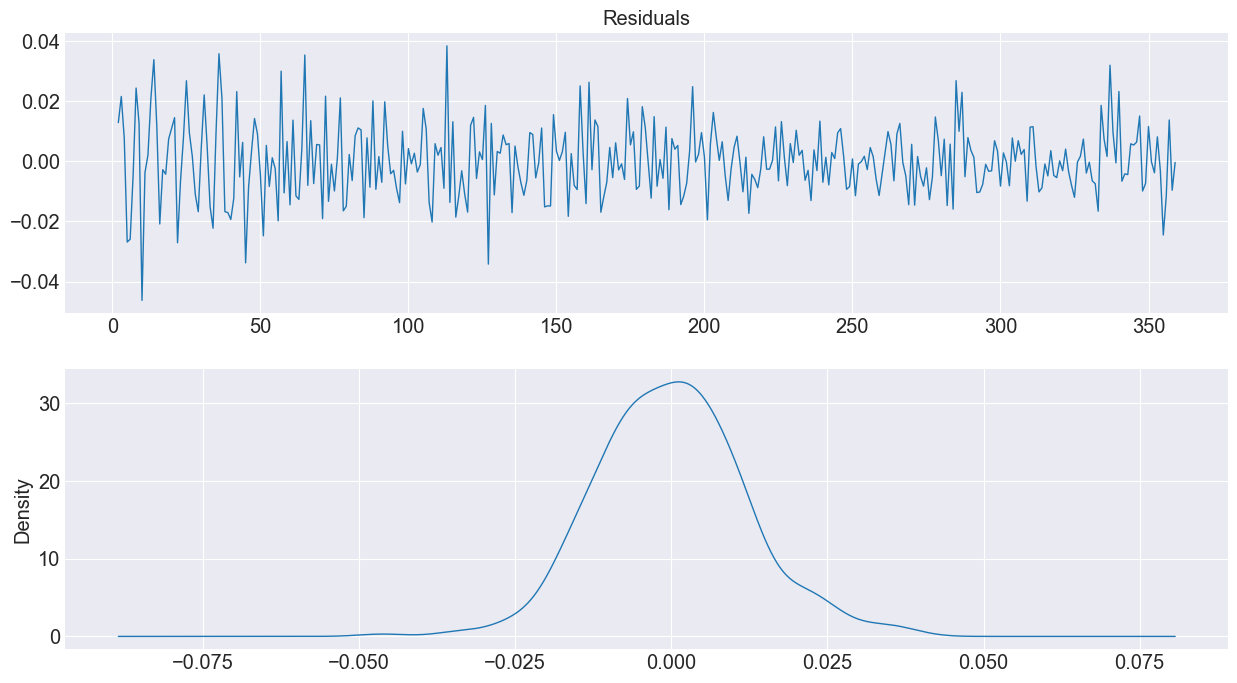

In [23]:
fig = plt.figure()

ax = fig.add_axes(211)

residuals = res.resid[1:]

residuals.plot(ax = ax, title = 'Residuals')

ax = fig.add_axes(212)

residuals.plot(kind = 'kde', ax = ax)

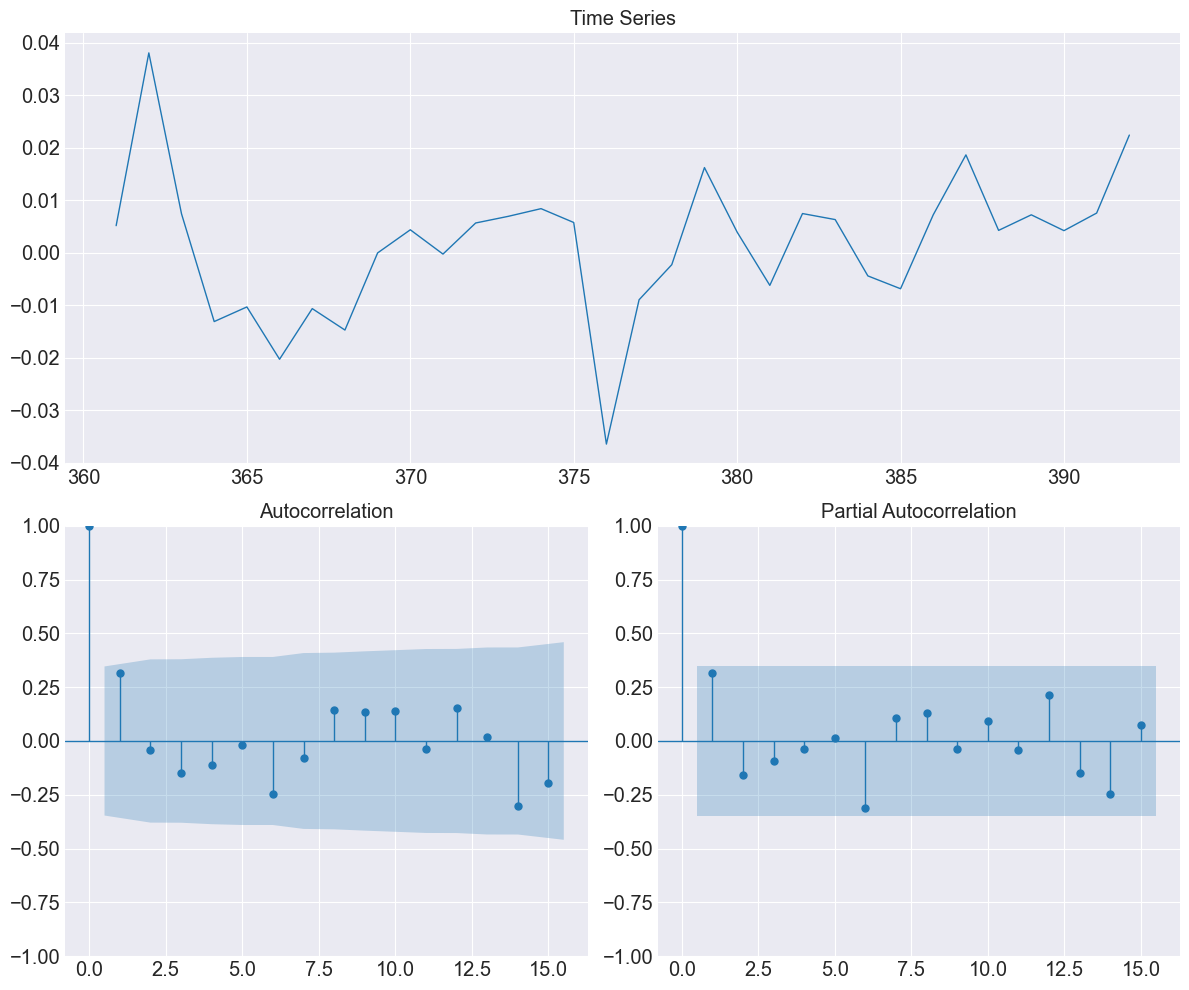

In [24]:
test_log_df = test_df.copy()

test_log_df['traffic'] = np.log(test_log_df['traffic'])

diff_train_df = test_log_df.diff().dropna()

plotds(diff_train_df['traffic'], nlag = 15)

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

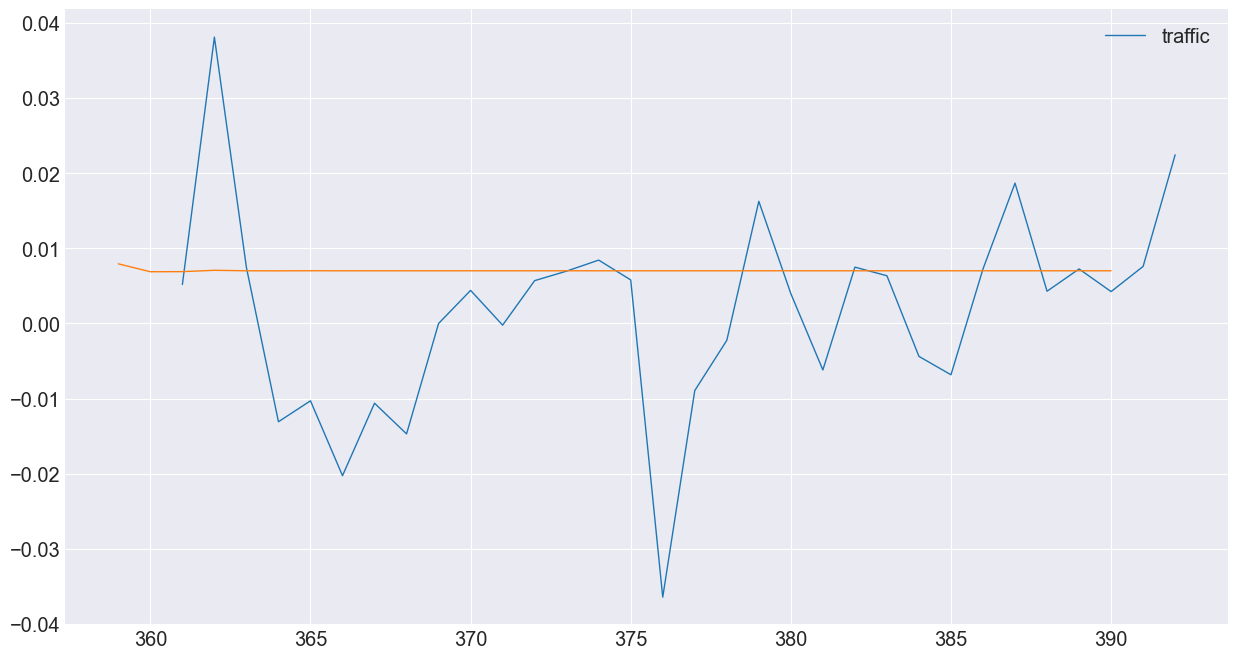

In [25]:
test_pred = res.forecast(diff_train_df.shape[0])

ax = diff_train_df.plot()

test_pred.plot(ax = ax)